In [215]:
import os
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils import data

from tools.pytorchtools import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

## Задание

Необходимо обучить нейросеть, способную по входному изображению лица
определять пол человека на изображении.

### Описание решения

Изначально было два пути решения: воспользоваться существующими сетями, например ResNet, приклеить к ней свои решающие слои и обучить в таком формате. Из плюсов: скорее всего получится очень точное решение. Минусы: state of the art решения, обученные на больших датасетах для определения многих классов в основном, как мне показалось, достаточно громоздки для такой простой бинарной классификации.

Всвязи с этим решил пойти по второму пути и спроектировать небольшую сеть, способную с приемлемой точностью решать поставленную задачу. В минусы такого подхода можно записать точность решения, которая скорее всего будет несколько ниже, чем у больших сетей, но в то же время оно получится легким, что в свою очередь означает более быстрое обучение. Для меня это критический момент, так как ресурсы ограничены. 

Подготовка фотографий включает в себя стандартные этапы: приведение к одному размеру (выбрал 64х64, относительно небольшой размер, чтобы ускорить обучение), далее перевод изображения в оттенки серого (датасет целиком состоит из лиц, я решил, что понимание оттенка кожи не должно как-то существенно влиять на качество предсказания) и в конце нормализацию значений пикселей к среднему 0.5 со стандартным отклонением 0.5, так как нейросети лучше работают с нормализованными значениями.

Начальную архитектуру сети выбрал, прочитав источники в интернете, в частности статью https://moluch.ru/conf/tech/archive/324/14834/
Добавил слои пуллинга и сконструировал полносвязные слои с последовательным понижением количества нейронов. Таким образом итоговая архитектура сети: 3 сверточных слоя, в каждом 64 ядра сверток 3х3, между каждым сверточным слоем слой макспулинга 2х2, далее глобальный пулинг по каждой свертке (на выходе вектор из 64 значений) и после 4 полносвязных слоя (64, 32, 16 и 1 нейронов соответственно). Функция активации в кажом сверточном и полносвязном слоях (кроме последнего) - ReLu. В качестве функции потерь была использована бинарная кросс-энтропия. Оптимизатор - Адам.

Гиперпараметры обучения оставлены по умолчанию. Сеть тренировалась в течение 56 эпох, на батчах по 512 картинок. Дополнительно при обучении был использован критерий ранней остановки: если значение функции потерь на валидационном датасете не уменьшалось в течение 5 эпох подряд - обучение останавливается. Скрипт тренировки также сохранял веса нейросети каждую эпоху, когда было улучшение на валидации в файл checkpoint.pt

В результате на отложенном датасете (8704 фотографии, которые сеть никогда не видела) сеть показала точность 95.7%. Были планы реализовать регуляризацию, но так как переобучение, судя по финальному графику, совсем небольшое, а тренировка и сравнение отняли бы порядка суток, решил отказаться от этой идеи. 

In [48]:
PATH = './data/internship_data'

In [59]:
transform = transforms.Compose([
                                transforms.Resize((64, 64)),
                                transforms.Grayscale(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), 
                                                     (0.5,))
])

In [162]:
batch_size = 512
num_classes = 2

classes = {0: 'female',
           1: 'male'}

In [60]:
dataset = datasets.ImageFolder(root = PATH, 
                               transform = transform)

In [61]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
val_size = int(0.7 * test_size)

In [217]:
# Разделение на train-validation-test
train_set, val_set = torch.utils.data\
    .random_split(dataset, [train_size, test_size])
    
val_set, test_set = torch.utils.data\
    .random_split(val_set, [val_size, test_size-val_size])

In [63]:
train_loader = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_loader = data.DataLoader(val_set, batch_size = batch_size, shuffle = True)
test_loader = data.DataLoader(test_set, batch_size = batch_size, shuffle = True)

In [89]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.mean([2, 3])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()

In [90]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

In [3]:
def train_model(model, patience, n_epochs): 
    """Function trains given model during n_epochs with early stopping
    criteria: train stops if validation loss does not decrease 
    during {patience} epochs.
    For correct work 'train_loader' and 'val_loader' must be defined
    
    Input
    -----
    model: neural network for training
    patience: int, number of epochs for early stopping
    n_epochs: int, number of epochs for training
    
    Output
    ------
    model: neural network loaded from checkpoint.pt.
           Last step of model when validation loss decreased
    avg_train_losses: list with average values of loss function 
                      during training through epochs
    avg_valid_losses: list with average values of loss function 
                      during validating through epochs
    """
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = [] 
    
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train()
        for batch, (data, target) in enumerate(train_loader, 1):
            target = target.unsqueeze(1)
            target = target.float()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in val_loader:
            target = target.unsqueeze(1)
            target = target.float()
            output = model(data)
            loss = criterion(output, target)
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

**ПРИ НЕОБХОДИМОСТИ ЗАНОВО ПРОВЕСТИ ТРЕНИРОВКУ ЗАМЕНИТЬ "if 0:" на "if 1:"**

In [106]:
n_epochs = 100
patience = 5

# Заменять здесь
if 0:
    model, train_loss, valid_loss = train_model(model, patience, n_epochs)

[  1/100] train_loss: 0.23279 valid_loss: 0.23279
Validation loss decreased (inf --> 0.232791).  Saving model ...
[  2/100] train_loss: 0.22715 valid_loss: 0.26040
EarlyStopping counter: 1 out of 5
[  3/100] train_loss: 0.22276 valid_loss: 0.21185
Validation loss decreased (0.232791 --> 0.211855).  Saving model ...
[  4/100] train_loss: 0.21334 valid_loss: 0.22438
EarlyStopping counter: 1 out of 5
[  5/100] train_loss: 0.20597 valid_loss: 0.20565
Validation loss decreased (0.211855 --> 0.205646).  Saving model ...
[  6/100] train_loss: 0.19949 valid_loss: 0.20032
Validation loss decreased (0.205646 --> 0.200316).  Saving model ...
[  7/100] train_loss: 0.19557 valid_loss: 0.19507
Validation loss decreased (0.200316 --> 0.195068).  Saving model ...
[  8/100] train_loss: 0.20090 valid_loss: 0.23672
EarlyStopping counter: 1 out of 5
[  9/100] train_loss: 0.18793 valid_loss: 0.17817
Validation loss decreased (0.195068 --> 0.178168).  Saving model ...
[ 10/100] train_loss: 0.18507 valid_los

## График изменения функции потерь

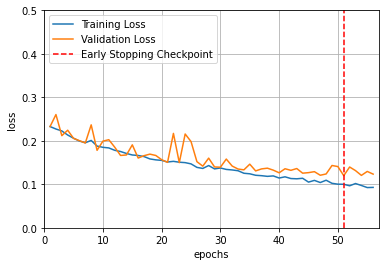

In [153]:
fig = plt.figure(figsize=(6,4))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5)
plt.xlim(0, len(train_loss)+1)
plt.grid(True)
plt.legend()
plt.show()

## Проверка модели на отложенном датасете

In [161]:
test_loss = 0.0
class_correct = [0] * num_classes
class_total = [0] * num_classes

model.eval()

for data_, target in test_loader:
    if len(target.data) != batch_size:
        break
    target = target.unsqueeze(1)
    target = target.float()
    output = model(data_)
    loss = criterion(output, target)
    test_loss += loss.item() * data_.size(0)
    
    # for multiclass: _, pred = torch.max(output, 1)
    pred = (np.squeeze(torch.sigmoid(output)) > 0.5) * 1
    
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    for i in range(batch_size):
        label = target.data[i]
        label = label.int()
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.6f}\n')

for i in range(num_classes):
    if class_total[i] > 0:
        class_accuracy = 100 * class_correct[i] / class_total[i]
        print(f'Test Accuracy of {classes[i]}: {class_accuracy:.2f}% '\
              f'({np.sum(class_correct[i])}/{np.sum(class_total[i])})')
              
    else:
        print(f'Test Accuracy of {classes[i]}: N/A (no training examples)')

overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
print(f'\nTest Accuracy (Overall): {overall_accuracy:.2f}% '\
      f'({np.sum(class_correct)}/{np.sum(class_total)})')

Test Loss: 0.113757

Test Accuracy of female: 96.30% (4164/4324)
Test Accuracy of male: 95.11% (4166/4380)

Test Accuracy (Overall): 95.70% (8330/8704)


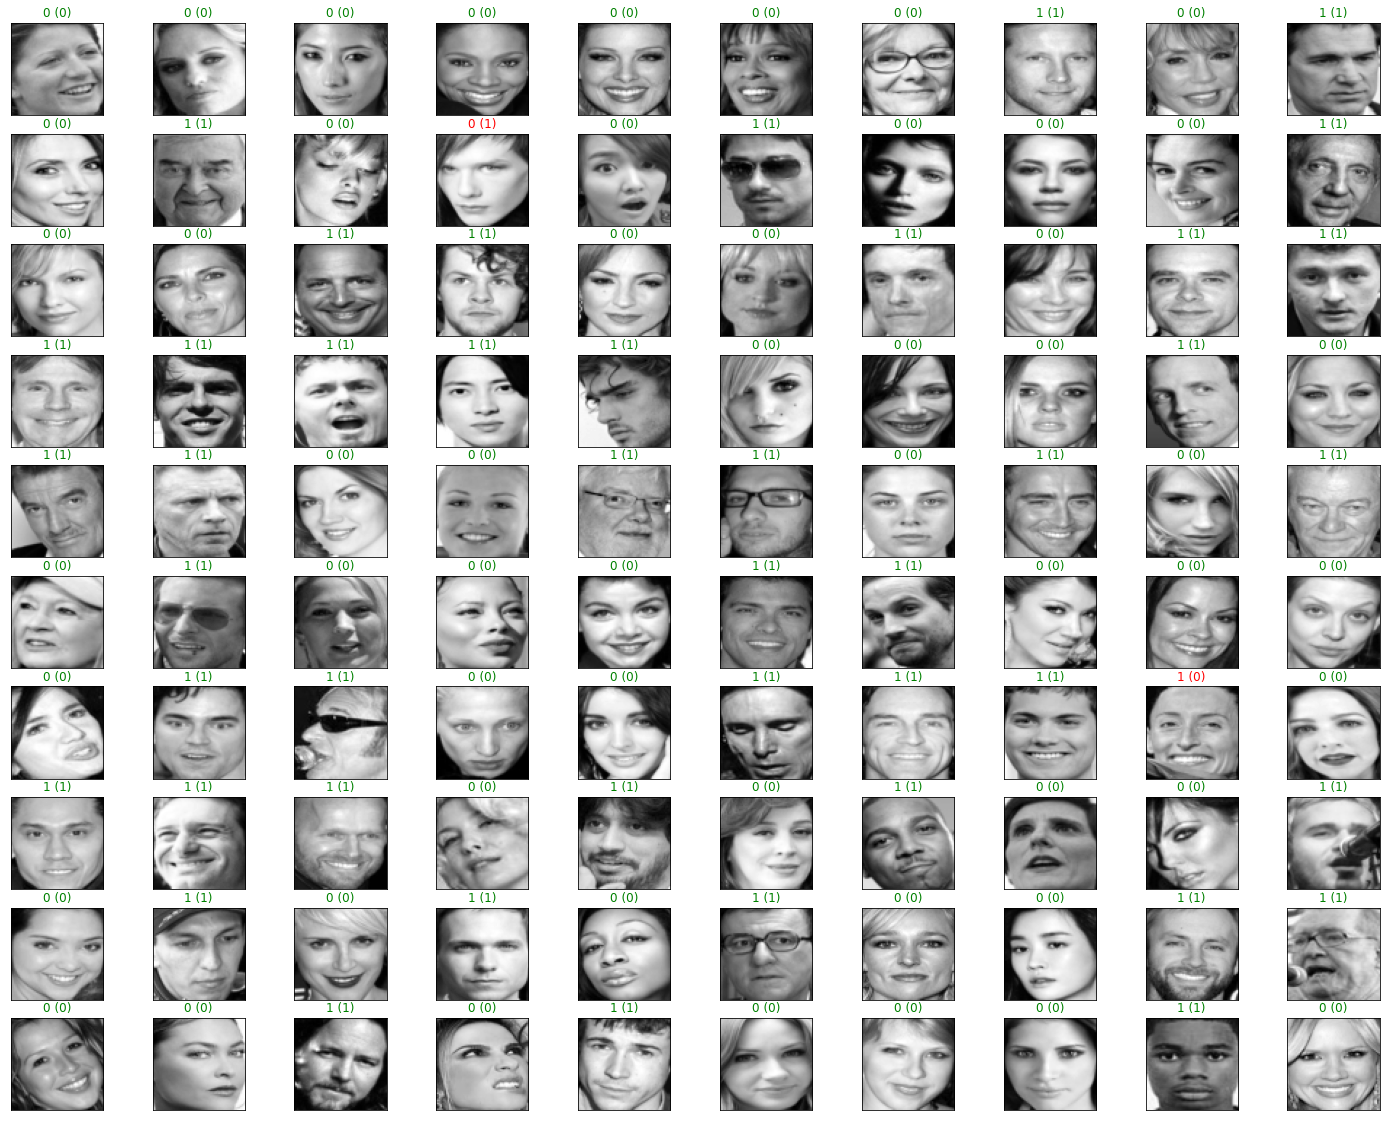

In [150]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

output = model(images)
preds = (np.squeeze(torch.sigmoid(output)) > 0.5) * 1
images = images.numpy()

fig = plt.figure(figsize=(25, 20))
for idx in np.arange(100):
    ax = fig.add_subplot(10, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

**ВЫВОДЫ**

Видно, что из 100 случайных примеров модель не справилась только с 2 достаточно спорными фотографиями. Думаю, часть людей также способны ошибиться на них. В остальном модель показывает достаточно неплохой результат. При этом она получилась легкой и неглубокой. К сожалению, мои вычислительные мощности не позволяют проверять много гипотез в условиях ограниченного времени (пользуюсь макбуком, поэтому пришлось тренировать на cpu). В ходе проверки модели нашлись примеры, где, как мне показалось, ошибки сети были вызваны обработкой фотографии, в частности, изменением масштаба: лицо меняло свои пропорции и становилось больше похоже на лицо противоположного пола. Поэтому для улучшения качества предсказаний можно попробовать: добавить цвет, увеличить размер фотографий + возможно, добавить дополнительные сверточные слои. С другой стороны можно воспользоваться существующими архитектурами, но, как я уже упоминал, мне показалось избыточным использовать сложные сети, предназначенные для мультиклассовой классификации, натренированные на больших датасетах вроде ImageNet. Скорее всего они легко справятся с определением пола, но, на мой взгляд, простое решение с незначительными просадками в точности по сравнению со state of the art сеятми будет смотреться выгоднее.

## Функция предсказаний

Функция дополнительно сохранена в файле make_predictions.py

In [216]:
import os
import json
import sys
import torch
import numpy as np

from torchvision import datasets, transforms
from torch.utils import data
from src.nn_structure import Net

def make_predictions(path):
    """Function makes predictions and saves them in file
     'process_results.json' in the given {path}
     Fotos should be stored inside additional folder in the
     given path (e.g. "path/data/")
     
     Input
     -------
     path: path where the file with results should be saved
           Fotos should be stored inside additional folder in the
           given path (e.g. "path/data/")
     """
    
    cur_dir = os.getcwd()
    output_dict = {}
    
    classes = {0: 'female',
               1: 'male'}
    
    model = Net()
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    transform = transforms.Compose([
                                transforms.Resize((64, 64)),
                                transforms.Grayscale(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), 
                                                     (0.5,))
    ])
    
    dataset = datasets.ImageFolder(root = path, 
                                   transform = transform)
    
    loader = data.DataLoader(dataset, batch_size = 1, shuffle = False)
    
    
    with torch.no_grad():
        for i, (image, label) in enumerate(loader, 0):
            output = model(image)
            prediction = (np.squeeze(torch.sigmoid(output.data)) > 0.5) * 1
            sample_path, _ = loader.dataset.samples[i]
            sample_fname = os.path.basename(sample_path)
            output_dict[sample_fname] = classes[prediction.item()]
    
    output_fname = os.path.join(path, 'process_results.json')
    
    with open(output_fname, 'w') as fp:
        json.dump(output_dict, fp)

In [214]:
make_predictions('./data/test_data/')